In [1]:
import datetime
import string

import nltk
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

# Глоссарий:
 - `views` - количество показов
 - `hits` - количество просмотров
 - `likes` - количество лайков статьи
 - `comments` - количество комментариев к статье
 - `favorites` - количество добавлений статьи в избранное
 - `tags` - теги статьи
 - `tags_count` - количество тегов у статьи
 - `title_len` - длина заголовка статьи (в символах)
 - `content_len` - длина контента статьи (в символах)
 - `date` - дата публикации статьи
 - `days_since_post` - количество дней с момента публикации статьи
 - `images_count` - количество изображений в статье
 - `author_name` - имя автора статьи
 - `author_total_views` - общее количество просмотров автора
 - `author_total_posts` - общее количество статей автора
 - `cluster` - номер кластера, к которому относится статья


In [2]:
spec_chars = string.punctuation + '\n\xa0«»\t—…–'


def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])


def join_all_titles(data):
    res = ''
    for i in range(len(data)):
        row = data.iloc[i]
        if type(row['title']) != str:
            continue
        res += '\n' + row['title']
    return res


def compute_frequent_words(data):
    text = join_all_titles(data)
    text = remove_chars_from_text(text, spec_chars)
    tokens = word_tokenize(text)
    freq_dict = FreqDist(nltk.Text([token.strip() for token in tokens if token not in russian_stopwords]))
    return freq_dict


def group_by(data, column: str):
    grouped = data.groupby(column)
    grouped_res = pd.DataFrame([], columns=[column, 'count', 'views', 'likes', 'comments', 'favorites', 'hits'])
    grouped_res[column] = grouped[column].first()
    grouped_res['count'] = grouped[column].count()
    grouped_res['views'] = grouped['views'].sum()
    grouped_res['likes'] = grouped['likes'].sum()
    grouped_res['comments'] = grouped['comments'].sum()
    grouped_res['favorites'] = grouped['favorites'].sum()
    grouped_res['hits'] = grouped['hits'].sum()
    grouped_res['avg_views'] = grouped_res['views'] / grouped_res['count']
    return grouped_res

In [3]:
data = pd.read_csv('./vc_posts.csv')
data = data[(data['title'].notnull()) & (data['is_advertisement'] == False)]
data['tags'] = data['tags'].apply(eval)
data['tags_count'] = data['tags'].apply(len)
data['title_len'] = data['title'].apply(len)
data['content_len'] = data['content'].apply(len)
data['date'] = data['date'].apply(datetime.datetime.strptime, args=('%a, %d %b %Y %H:%M:%S %z',))
data['days_since_post'] = data['date'].apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).days)
data['images_count'] = data['content'].apply(lambda x: x.count('<img'))
grouped_by_author = group_by(data, 'author_name')
data['author_total_views'] = data['author_name'].apply(
    lambda x: grouped_by_author[grouped_by_author['author_name'] == x]['views'].values[0])
data['author_total_posts'] = data['author_name'].apply(
    lambda x: grouped_by_author[grouped_by_author['author_name'] == x]['count'].values[0])
data.head()

,_id,author_name,author_type,comments,content,createdAt,date,favorites,hits,id,...,title,url,views,tags_count,title_len,content_len,days_since_post,images_count,author_total_views,author_total_posts
0,6616c4acd2ad343afb59d936,Успешный провал,self,2,"<div class=""l-island-a"">\n \n <p>Отк...",2024-04-10T16:56:12.412Z,2024-04-09 18:42:14+03:00,0,372,1118037,...,Как потерять бизнес за три месяца,https://vc.ru/life/1118037-kak-poteryat-biznes...,2644,0,33,17238,11,1,5478,3
1,6616c4acd2ad343afb59d935,Realm Digital,self,2,"<figure class=""figure-image"">\n <style>\n ...",2024-04-10T16:56:12.060Z,2024-04-08 17:01:57+03:00,1,64,1115687,...,Зачем Вашему Бизнесу Профессиональный Веб-Сайт?,https://vc.ru/life/1115687-zachem-vashemu-bizn...,790,0,47,7480,12,1,790,1
2,6616c4abd2ad343afb59d934,Таня Боброва,editor,102,"<div class=""l-island-a"">\n \n <p>Ком...",2024-04-10T16:56:11.889Z,2024-04-09 13:19:04+03:00,9,4649,1117264,...,Отчёт Ozon за год: выручка выросла на 53% — до...,https://vc.ru/money/1117264-otchet-ozon-za-god...,16068,3,141,4870,11,0,1698894,964
3,6616c4abd2ad343afb59d933,Pyrobyte,self,17,"<div class=""l-island-a"">\n \n <p>При...",2024-04-10T16:56:11.606Z,2024-04-09 07:47:32+03:00,31,903,1110527,...,8 лучших сервисов для автоматизации транспортн...,https://vc.ru/transport/1110527-8-luchshih-ser...,10583,0,70,50264,11,2,74494,7
4,6616c4abd2ad343afb59d932,Timur Taepov,self,0,"<div class=""l-island-a"">\n \n <p>Это...",2024-04-10T16:56:11.119Z,2024-04-09 19:28:03+03:00,2,47,1118101,...,Как создать AI-продукт новичку? Базовые поняти...,https://vc.ru/chatgpt/1118101-kak-sozdat-ai-pr...,501,0,61,7340,11,0,1398,2


# Данные сгруппированные по тематике и отсортированные по среднему количеству просмотров

In [4]:
grouped_subsite = group_by(data, 'subsite_label')
grouped_subsite.sort_values(by='avg_views', ascending=False).head(10)

,subsite_label,count,views,likes,comments,favorites,hits,avg_views
subsite_label,,,,,,,,
molyanov,molyanov,2,53163,280,275,292,29646,26581.500000
ratingruneta,ratingruneta,3,55506,263,345,101,9971,18502.000000
ya-specialist,ya-specialist,3,52133,153,283,38,6895,17377.666667
finder,finder,3,49653,166,266,107,20003,16551.000000
awake_journal_ru,awake_journal_ru,1,14187,42,119,11,2637,14187.000000
igotosochi,igotosochi,32,395863,414,1149,363,81685,12370.718750
begovatovd,begovatovd,22,268295,1034,1330,891,77612,12195.227273
volts,volts,1,9461,42,37,24,2813,9461.000000
nikanorova,nikanorova,4,37594,297,338,477,191253,9398.500000


# Данные сгруппированные по тематике и отсортированные по количеству просмотров

In [5]:
grouped_subsite.sort_values(by='views', ascending=False).head(10)

,subsite_label,count,views,likes,comments,favorites,hits,avg_views
subsite_label,,,,,,,,
marketing,marketing,2880,3488988,51466,36184,113948,16358339,1211.454167
unknown,unknown,10759,3471474,22200,24525,17312,9202893,322.657682
money,money,1881,2708191,45658,81311,56165,16377092,1439.761297
life,life,1079,2025319,34246,30104,55272,9619967,1877.033364
services,services,1160,1338297,32392,40936,47476,13940915,1153.704310
legal,legal,733,1030489,16366,32095,14265,6003769,1405.851296
trade,trade,736,1016924,18944,31079,23705,6860712,1381.690217
claim,claim,1009,952317,19969,40432,3972,5415358,943.822597
design,design,648,813164,20621,16046,38238,5146462,1254.882716


In [6]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это'])

# Семантический анализ заголовков статей
## Делим на 2 кластера

In [7]:
vec = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 3))
vec.fit(data['title'])
features = vec.transform(data['title'])

cluster = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster.fit(features)

yhat = cluster.predict(features)
data['cluster'] = yhat

In [21]:
grouped_cluster = group_by(data, 'cluster')
grouped_cluster[['count', 'views', 'likes', 'comments', 'avg_views']].head(20)

,count,views,likes,comments,avg_views
cluster,,,,,
0,376,462333,12400,20366,1229.609043
1,688,662323,12989,12428,962.678779
2,20743,15044225,237988,213439,725.267560
3,656,871901,6661,9311,1329.117378
4,3918,5116212,149836,270783,1305.822358
5,509,500830,7729,5466,983.948919
6,537,435718,12843,16491,811.392924
7,406,197745,1405,4245,487.056650
8,118,66419,2221,1229,562.872881


In [22]:
sub_set = data[data['cluster'] == 1]
sub_set[['title', 'views', 'hits', 'cluster']].head(40)

,title,views,hits,cluster
64,"Почему вы много работаете, а зарабатываете сил...",34930,8838,1
75,Clubhouse — почему я не буду там регистрироваться,1133,38972,1
175,"Кейс ""Тату-мастер из Барнаула"" или почему не с...",178,14,1
201,Почему мы боимся джунов?,4124,658,1
231,Почему социальные медиа стали неотъемлемой час...,419,35,1
249,Почему люди слушают рок? Какое влияние он оказ...,34,40,1
251,"Неожиданная причина, почему ваш блог может дре...",727,50,1
256,На чем стоит Астрология. И почему сейчас это н...,30,13,1
346,Почему вы должны использовать маркетинг на осн...,16,9,1
376,Деньги из страха - почему такая мотивация к за...,67,9,1


In [23]:
sub_set = data[data['cluster'] == 0]
sub_set[['title', 'views', 'hits', 'cluster']].head(40)

,title,views,hits,cluster
25,Выручка Apple в России упала более чем в 23 ра...,27586,6839,0
76,Авторизованный ремонт Apple в России: стоит ли...,20510,721,0
223,"Приложение для девушек “Наш Краш”, где они смо...",6889,1551,0
407,Apple планирует добавить в iPhone системы иску...,1552,63,0
547,Apple удалила приложение КриптоПро из Appstore...,851,1343,0
590,"Костин и Греф двигают рынком, Apple выкинул св...",1599,194,0
603,Apple представила 13- и 15-дюймовые MacBook Ai...,42866,18418,0
889,Искусственный интеллект Apple AI анонсируют вм...,2,21,0
1439,"Apple подтверждает, что намеренно взламывает в...",193,44,0
1756,Apple активно покупает стартапы в области иску...,940,78,0


# Пробуем разделить на 10 кластеров

In [25]:
cluster = KMeans(n_clusters=10, random_state=42, n_init=10)
cluster.fit(features)

yhat = cluster.predict(features)
data['cluster'] = yhat

grouped_cluster = group_by(data, 'cluster')

grouped_cluster[['cluster', 'count', 'views', 'likes', 'hits', 'comments', 'avg_views']].head(10)

,cluster,count,views,likes,hits,comments,avg_views
cluster,,,,,,,
0,0,376,462333,12400,4033450,20366,1229.609043
1,1,688,662323,12989,3977471,12428,962.678779
2,2,20743,15044225,237988,77968302,213439,725.267560
3,3,656,871901,6661,3450008,9311,1329.117378
4,4,3918,5116212,149836,57305584,270783,1305.822358
5,5,509,500830,7729,3918971,5466,983.948919
6,6,537,435718,12843,3443563,16491,811.392924
7,7,406,197745,1405,422446,4245,487.056650
8,8,118,66419,2221,983547,1229,562.872881


In [27]:
data[['title', 'views', 'hits', 'cluster']].head(40)

,title,views,hits,cluster
0,Как потерять бизнес за три месяца,2644,372,2
1,Зачем Вашему Бизнесу Профессиональный Веб-Сайт?,790,64,9
2,Отчёт Ozon за год: выручка выросла на 53% — до...,16068,4649,4
3,8 лучших сервисов для автоматизации транспортн...,10583,903,3
4,Как создать AI-продукт новичку? Базовые поняти...,501,47,2
5,ФАС выдала Wildberries предупреждение из-за пр...,22877,5783,4
6,Как владельцы блогов в Telegram теряют деньги,5345,632,2
7,Как мы встречаем День Космонавтики в ювелирке:...,22896,1225,2
8,ФАС выдала Wildberries предупреждение из-за пр...,22877,5783,4
9,"ТОП-3 способа ведения конспектов, которые помо...",3897,200,5


# Самые популярные слова в заголовках статей

In [13]:
compute_frequent_words(data).most_common(20)

[('Статьи', 4418),
 ('России', 610),
 ('Как', 535),
 ('млн', 525),
 ('редакцииКак', 518),
 ('рублей', 430),
 ('которые', 368),
 ('сервис', 337),
 ('компании', 335),
 ('года', 316),
 ('бизнес', 276),
 ('помощью', 271),
 ('2023', 266),
 ('млрд', 263),
 ('бизнеса', 262),
 ('изза', 260),
 ('почему', 258),
 ('1', 250),
 ('деньги', 246),
 ('Google', 240)]

# Самые популярные слова в заголовках статей с более чем 10К просмотров


In [14]:
compute_frequent_words(data[data['views'] > 10_000]).most_common(20)

[('Статьи', 220),
 ('года', 35),
 ('России', 34),
 ('2023', 33),
 ('рублей', 32),
 ('редакцииКак', 27),
 ('млн', 24),
 ('которые', 18),
 ('10', 17),
 ('году', 16),
 ('тысяч', 16),
 ('Как', 15),
 ('млрд', 14),
 ('2024', 13),
 ('компании', 12),
 ('Telegram', 12),
 ('бизнес', 11),
 ('коротко', 11),
 ('1', 11),
 ('редакцииДень', 11)]

# Корреляционная матрица

In [15]:
cormat = data[
    ['views', 'tags_count', 'favorites', 'likes', 'comments', 'hits', 'title_len', 'content_len', 'images_count',
     'days_since_post', 'author_total_posts', 'author_total_views']].corr()
cormat

,views,tags_count,favorites,likes,comments,hits,title_len,content_len,images_count,days_since_post,author_total_posts,author_total_views
views,1.000000,0.009889,0.030058,0.134470,0.282145,0.010243,0.080177,0.058783,-0.042740,-0.180417,0.021843,0.142790
tags_count,0.009889,1.000000,0.016304,0.082803,0.126015,0.072138,0.214828,-0.007054,0.066729,0.098815,0.250841,0.176466
favorites,0.030058,0.016304,1.000000,0.604590,0.267797,0.481472,0.091523,0.334574,0.151672,0.269056,-0.002951,-0.000824
likes,0.134470,0.082803,0.604590,1.000000,0.591520,0.617801,0.205058,0.241475,0.162056,0.316148,0.127847,0.083083
comments,0.282145,0.126015,0.267797,0.591520,1.000000,0.322686,0.291362,0.053800,0.075068,0.145996,0.252115,0.276131
hits,0.010243,0.072138,0.481472,0.617801,0.322686,1.000000,0.120958,0.187575,0.112420,0.240920,0.069722,0.039954
title_len,0.080177,0.214828,0.091523,0.205058,0.291362,0.120958,1.000000,0.054561,0.114014,0.264251,0.505829,0.388285
content_len,0.058783,-0.007054,0.334574,0.241475,0.053800,0.187575,0.054561,1.000000,0.229771,0.171719,-0.150349,-0.113774
images_count,-0.042740,0.066729,0.151672,0.162056,0.075068,0.112420,0.114014,0.229771,1.000000,0.378426,0.118143,0.034130
days_since_post,-0.180417,0.098815,0.269056,0.316148,0.145996,0.240920,0.264251,0.171719,0.378426,1.000000,0.303944,0.095101


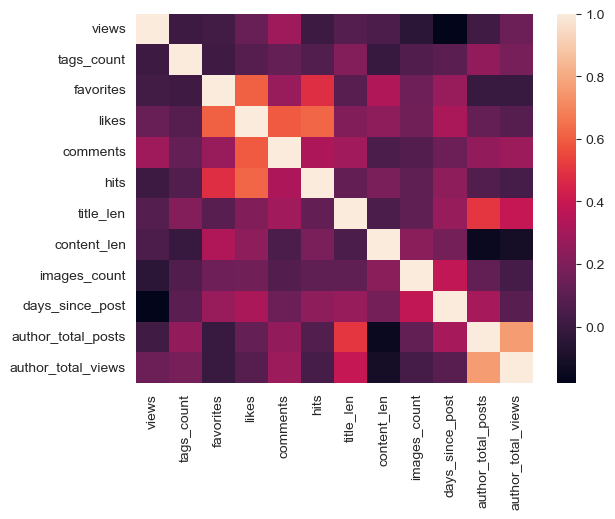

In [16]:
sns.heatmap(cormat);

## Заключения
- VC продвигает посты с большим количеством лайков и комментариев (лайки и комментарии коррелируют с просмотрами больше, чем сами просмотры)
- Есть корреляция между длиной контента и лайками + добавлениями в избранное
- Есть слабая корреляция между длиной заголовка и лайками + комментариями
- Есть корреляция между количеством тэгов и просмотрами

# Scatter plots

Text(0, 0.5, 'Просмотры')

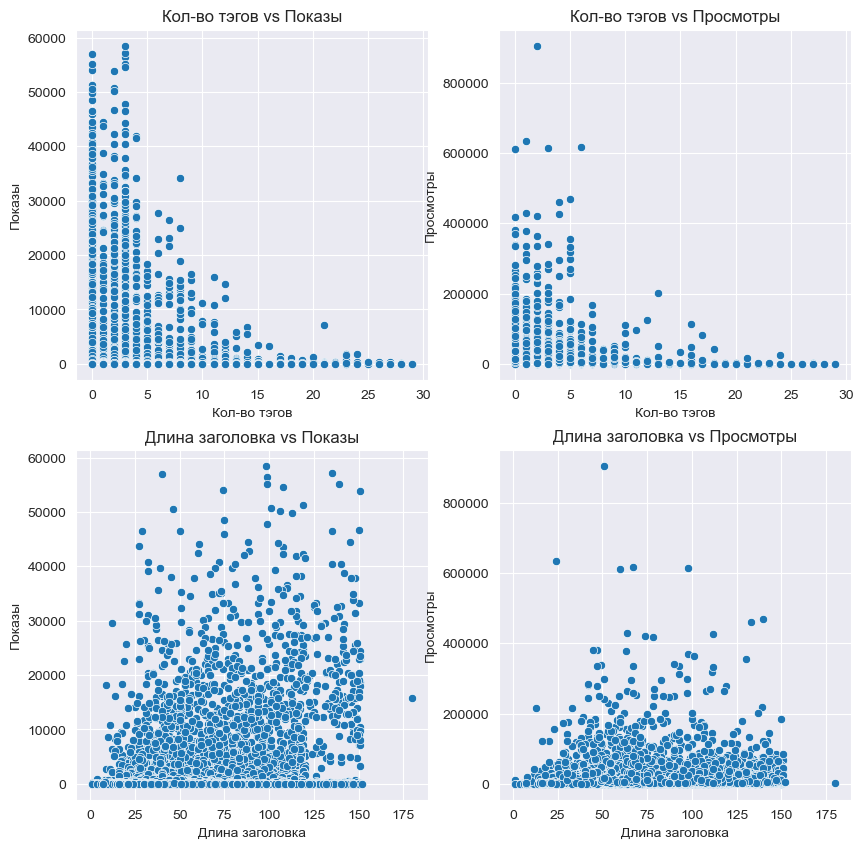

In [17]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

_data = data[(data['views'] < 60_000) & (data['tags_count'] < 30)]
ax = sns.scatterplot(x="tags_count", y="views", data=_data, ax=axs[0, 0])
ax.set_title('Кол-во тэгов vs Показы')
ax.set_xlabel('Кол-во тэгов')
ax.set_ylabel('Показы')

_data = data[(data['hits'] < 1_000_000) & (data['tags_count'] < 30)]
ax = sns.scatterplot(x="tags_count", y="hits", data=_data, ax=axs[0, 1])
ax.set_title('Кол-во тэгов vs Просмотры')
ax.set_xlabel('Кол-во тэгов')
ax.set_ylabel('Просмотры')

_data = data[(data['views'] < 60_000)]
ax = sns.scatterplot(x="title_len", y="views", data=_data, ax=axs[1, 0])
ax.set_title('Длина заголовка vs Показы')
ax.set_xlabel('Длина заголовка')
ax.set_ylabel('Показы')

_data = data[(data['hits'] < 1_000_000)]
ax = sns.scatterplot(x="title_len", y="hits", data=_data, ax=axs[1, 1])
# ax.set_title('Title length vs Hits')
ax.set_title('Длина заголовка vs Просмотры')
ax.set_xlabel('Длина заголовка')
ax.set_ylabel('Просмотры')

Text(0, 0.5, 'Комментарии')

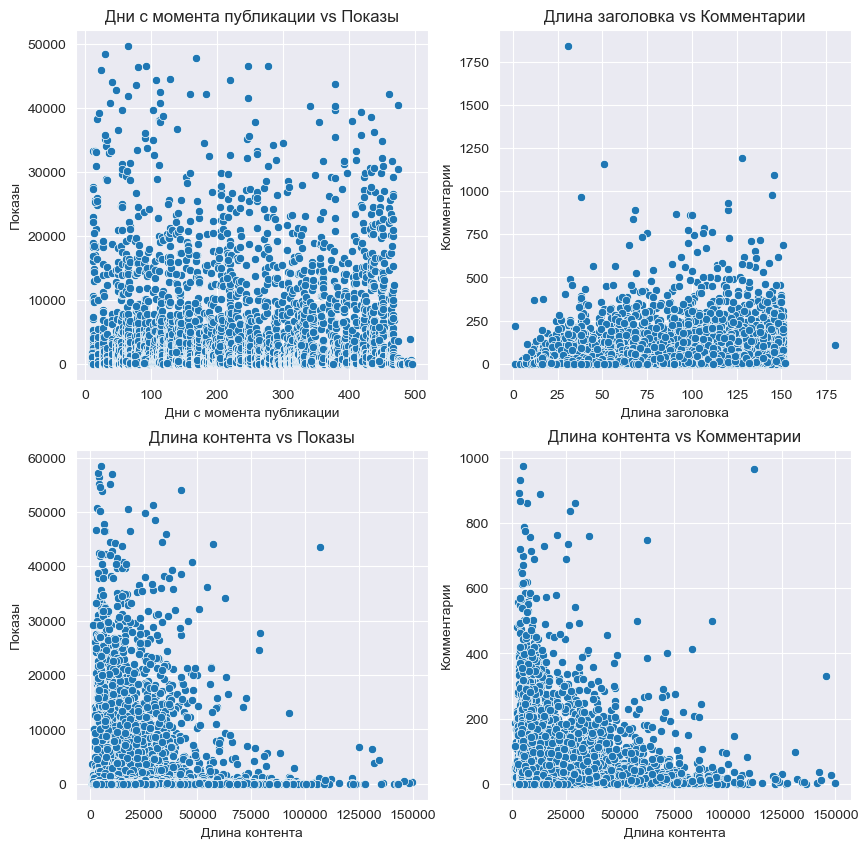

In [18]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
_data = data[(data['views'] < 50_000) & (data['days_since_post'] < 500)]
ax = sns.scatterplot(x="days_since_post", y="views", data=_data, ax=axs[0, 0])
ax.set_title('Дни с момента публикации vs Показы')
ax.set_xlabel('Дни с момента публикации')
ax.set_ylabel('Показы')

ax = sns.scatterplot(x="title_len", y="comments", data=data, ax=axs[0, 1])
ax.set_title('Длина заголовка vs Комментарии')
ax.set_xlabel('Длина заголовка')
ax.set_ylabel('Комментарии')

_data = data[(data['content_len'] < 150_000) & (data['views'] < 60_000)]
ax = sns.scatterplot(x="content_len", y="views", data=_data, ax=axs[1, 0])
ax.set_title('Длина контента vs Показы')
ax.set_xlabel('Длина контента')
ax.set_ylabel('Показы')

_data = data[(data['content_len'] < 150_000) & (data['comments'] < 1000)]
ax = sns.scatterplot(x="content_len", y="comments", data=_data, ax=axs[1, 1])
ax.set_title('Длина контента vs Комментарии')
ax.set_xlabel('Длина контента')
ax.set_ylabel('Комментарии')

Text(0, 0.5, 'Показы')

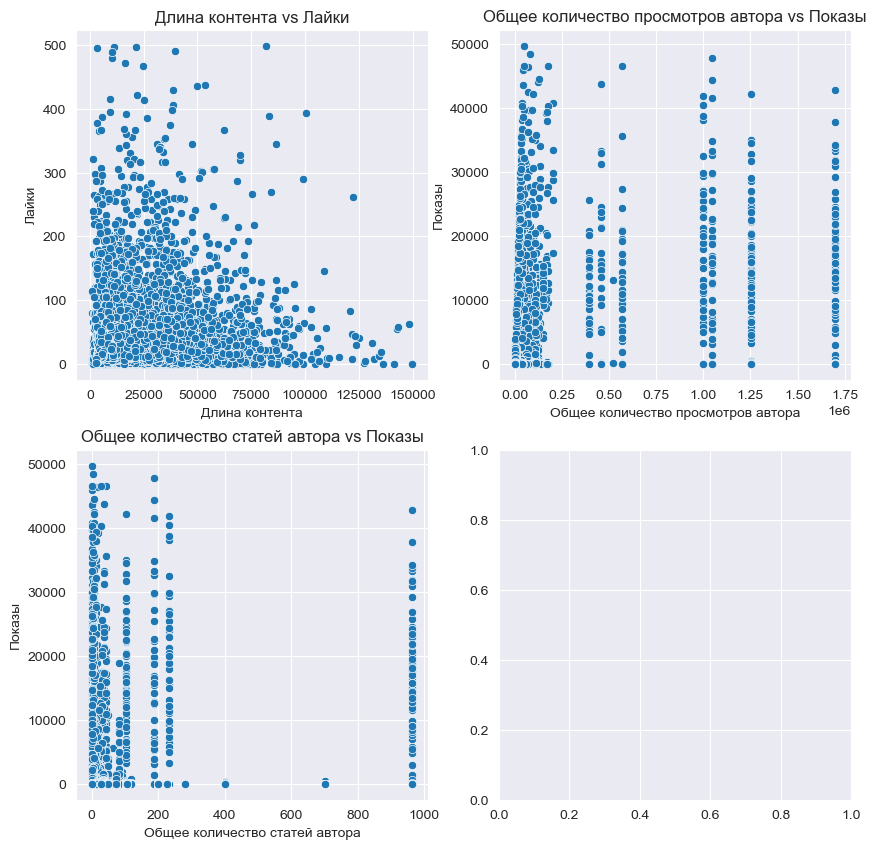

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

_data = data[(data['content_len'] < 150_000) & (data['likes'] < 500)]
ax = sns.scatterplot(x="content_len", y="likes", data=_data, ax=axs[0, 0])
ax.set_title('Длина контента vs Лайки')
ax.set_xlabel('Длина контента')
ax.set_ylabel('Лайки')

_data = data[(data['views'] < 50_000) & (data['author_total_views'] < 5_000_000)]
ax = sns.scatterplot(x="author_total_views", y="views", data=_data, ax=axs[0, 1])
ax.set_title('Общее количество просмотров автора vs Показы')
ax.set_xlabel('Общее количество просмотров автора')
ax.set_ylabel('Показы')

_data = data[(data['views'] < 50_000) & (data['author_total_posts'] < 1000)]
ax = sns.scatterplot(x="author_total_posts", y="views", data=_data, ax=axs[1, 0])
ax.set_title('Общее количество статей автора vs Показы')
ax.set_xlabel('Общее количество статей автора')
ax.set_ylabel('Показы')